In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

# Encoder semplice
class SimpleEncoder(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, dim)
        )

    def forward(self, x):
        return self.net(x)

# DINO loss
def dino_loss(student_out, teacher_out, temp_s=0.1, temp_t=0.07):
    student_logits = F.log_softmax(student_out / temp_s, dim=-1)
    teacher_probs = F.softmax(teacher_out / temp_t, dim=-1)
    return -torch.sum(teacher_probs * student_logits, dim=-1).mean()

# EMA update
@torch.no_grad()
def update_teacher(student, teacher, ema_rate=0.996):
    for s, t in zip(student.parameters(), teacher.parameters()):
        t.data = ema_rate * t.data + (1 - ema_rate) * s.data

# Generazione dati strutturati
def create_structured_data(n_samples=32):
    #class1:  RGB images  32×32 
    #         Values centered at +0.6 -> white/yellow 
    class1 = torch.randn(n_samples // 2, 3, 32, 32) * 0.2 + 0.6 
    
    #class2:  RGB images  32×32 
    #         Values centered at -0.6 -> black/blue 
    class2 = torch.randn(n_samples // 2, 3, 32, 32) * 0.2 - 0.6
    return torch.cat([class1, class2], dim=0)

# Inizializza modelli
student = SimpleEncoder()
teacher = copy.deepcopy(student)
for p in teacher.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

# Crea dummy data
x = create_structured_data()

# Due viste augmentate
x1 = x + 0.05 * torch.randn_like(x)
x2 = torch.roll(x, shifts=1, dims=3) + 0.05 * torch.randn_like(x)

# Training loop
for epoch in range(100):
    student_out = student(x1)
    with torch.no_grad():
        teacher_out = teacher(x2)

    loss = dino_loss(student_out, teacher_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    update_teacher(student, teacher)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


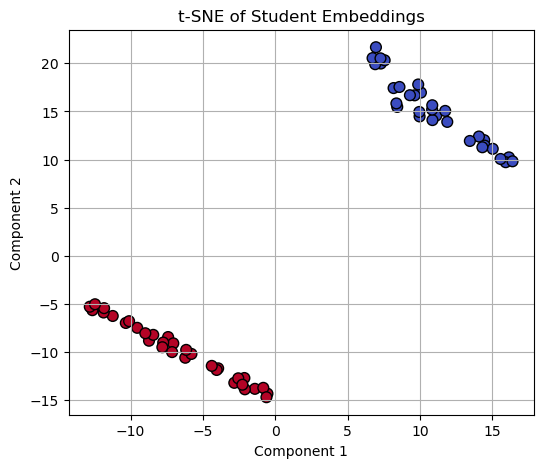

In [9]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
 
# Funzione per generare nuovi dati strutturati con etichette
def create_structured_data_with_labels(n_samples=64):
    class1 = torch.randn(n_samples // 2, 3, 32, 32) * 0.2 + 0.6
    class2 = torch.randn(n_samples // 2, 3, 32, 32) * 0.2 - 0.6
    data = torch.cat([class1, class2], dim=0)
    labels = torch.tensor([0] * (n_samples // 2) + [1] * (n_samples // 2))
    return data, labels

# Ottieni gli embedding dallo student model
def get_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        return model(data).cpu().numpy()

# Visualizza gli embedding con t-SNE
def visualize_tsne(embeddings, labels):
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(6, 5))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap="coolwarm", edgecolors="k", s=60)
    plt.title("t-SNE of Student Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Esempio d'uso
X_vis, y_vis = create_structured_data_with_labels()
embeddings = get_embeddings(student, X_vis)
visualize_tsne(embeddings, y_vis)
